# 设置

In [1]:
import os, subprocess
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm import trange
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF_F
from torchvision.utils import make_grid

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d.axes3d import Axes3D, art3d
from matplotlib.patches import Circle

# stable outputs across different runs
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# 自动获取占用内存最少的gpu编号

In [2]:
# get device to calculate on (either CPU or GPU with minimum memory load)
def get_gpu_memory_map():
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    
    return gpu_memory_map

def get_device():
    if torch.cuda.is_available():
        memory_map = get_gpu_memory_map()
        device = "cuda:%d" % min(memory_map, key=memory_map.get)
    else:
        device = "cpu"
    
    print("Device:", device)
    return device

# CIFAR10 数据集

In [3]:
# Here I defined a FloatTransformer class which in
# __call__ method takes a matrix tensor as an input 
# and return a torch float tensor

class FloatTransformer(object):
    def __call__(self, tensor):
        return tensor.type(torch.FloatTensor)

    
## load CIFAR10 dataset
root = './static/data/CIFAR10/CIFAR10/'
if not os.path.exists(root):
    os.mkdir(root)
# here I set the size of train and test dataset
batch_size = 128
train_size = 8192
test_size = 1024
    
# here we need to normalize images for the the relavent function

trans = transforms.Compose([transforms.ToTensor(),
                            FloatTransformer(), #[0,255]->[0,1]
                            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   #(R-0.5)/0.5 ,(G-0.5)/0.5 ,(B-0.5)/0.5  #pyTorch Document example [0,1]->[-1,1]
                            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261) #https://github.com/kuangliu/pytorch-cifar/

# get training dataset and extract a random subset of 8192 images for training
dataset_train = dset.CIFAR10(root=root, train=True, transform=trans, download=True)
# dataset_train, _ = torch.utils.data.random_split(dataset_train, [train_size, len(dataset_train)-train_size])

# get test dataset and extract a random subset of 1024 images for testing
dataset_test = dset.CIFAR10(root=root, train=False, transform=trans, download=True)
# dataset_test, _ = torch.utils.data.random_split(dataset_test, [test_size, len(dataset_test)-test_size])

#These are the classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# the dataloader load the images(datasets)
# then with the size of the batch_size which
# I set above make them split and then shuffle as well

dataloader_train = torch.utils.data.DataLoader(
                 dataset=dataset_train,
                 batch_size=batch_size,
                 shuffle=False)

# The dataloader here do the same 
#operation from above for test dataset 

dataloader_test = torch.utils.data.DataLoader(
                dataset=dataset_test,
                batch_size=batch_size,
                shuffle=False)

#Here I displyed the size of the train & test images

print("Train images: {} Batches: {}".format(len(dataset_train), len(dataloader_train)))
print("Test images: {} Batches: {}".format(len(dataset_test), len(dataloader_test)))

Files already downloaded and verified
Files already downloaded and verified
Train images: 50000 Batches: 391
Test images: 10000 Batches: 79


# 展示原始图片

 frog truck truck  deer   car   car  bird horse


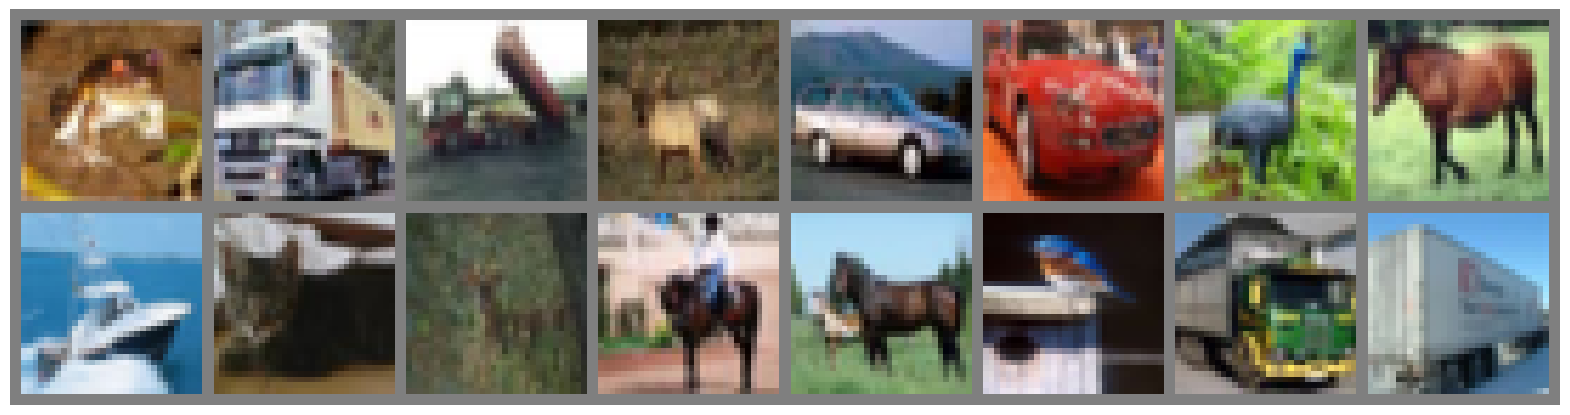

 ship   cat  deer horse horse  bird truck truck


In [4]:
# In this section I try to show some random images
def imshow(img):
    plt.figure(figsize=(20,10))
    img=img/2+0.5 #[-1,1]-->[0,1]
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
# get some random training images
dataiter = iter(dataloader_train)
images, labels = dataiter.next()

# show images
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))
imshow(make_grid(images[:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(8,16)))

# 定义AE

In [5]:
# Here We defined three convolutional layers for authoencoder
# each cnn layer contains: "conv2","BatchNorm2d" and  Relu activation function
n_layers='3_layer'
# implement autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(3, 12, kernel_size=4, stride=2, padding=1), #3x32x32 to 12x16x16
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1), #12x16x16 to 24x8x8
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 48, kernel_size=4, stride=2, padding=1), #24x8x8 to 48x4x4
            nn.BatchNorm2d(48),
            nn.ReLU(),
            # nn.Conv2d(48, 96, kernel_size=4, stride=2, padding=1), #48x4x4 to 96x2x2
            # nn.BatchNorm2d(96),
            # nn.ReLU(),
            #nn.Conv2d(96, 192, kernel_size=4, stride=2, padding=1), #96x2x2 to 192x1x1
            #nn.BatchNorm2d(192),
            #nn.ReLU()
        )

        # kjl多加一个类别层
        self.classifier = nn.Sequential(
            nn.Linear(192, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 10),
        )
        
        self.decoder = nn.Sequential(
            #nn.ConvTranspose2d(192, 96, kernel_size=4, stride=2, padding=1, output_padding=0), #192x1x1 to 96x2x2
            #nn.BatchNorm2d(96),
            #nn.ReLU(),
            # nn.ConvTranspose2d(96, 48, kernel_size=4, stride=2, padding=1, output_padding=0), #96x2x2 to 48x4x4
            # nn.BatchNorm2d(48),
            # nn.ReLU(),
            nn.ConvTranspose2d(48, 24, kernel_size=4, stride=2, padding=1, output_padding=0), #48x4x4 to 24x8x8
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, kernel_size=4, stride=2, padding=1, output_padding=0), #24x8x8 to 12x16x16
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, kernel_size=4, stride=2, padding=1, output_padding=0), #12x16x16 to 3x32x32
            nn.BatchNorm2d(3),
            nn.Tanh()
        )
  # defined the forward function to take input
  # call the encoder to encod the input
  # call the decoder function to decode the encoded inpu
    def forward(self, x):
        encoded = self.encoder(x)

        temp = nn.AvgPool2d(2,2)(encoded)
        emb = temp.view(encoded.size(0), -1) #flatten
        pre = self.classifier(emb)

        decoded = self.decoder(encoded)
        return encoded, decoded, pre

    #with an pooling on output of trained encoder we have an embeding vector for each image 
    #this vector can used for MLP or other method for prediction
    def embedding(self,x):
        encoded = self.encoder(x)
        encoded = nn.AvgPool2d(2,2)(encoded) #48*4*4-->48x2x2 embedded features 
        encoded = encoded.view(encoded.size(0), -1)   #flatten 48x2x2->192
        return encoded

# 设置gpu

In [6]:
#First we set GPu usage 
#Then make a model
device = get_device()
temp_model = Autoencoder().to(device)
print("########Autoencoder########")
print("encoder:")
print(temp_model.encoder)
print("decoder:")
print(temp_model.decoder)
print("classifier:")
print(temp_model.classifier)

Device: cuda:0
########Autoencoder########
encoder:
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
)
decoder:
Sequential(
  (0): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): ConvTranspose2d(12,

# 测试模型的输出

In [7]:
#test model input output size
# here we can see we passed 128 images
# with size of 32X32  --> encode to 4X 4 then  decode --> 32X 32
for input_imgs, _ in dataloader_train:
        input_imgs= input_imgs.to(device)
        encoded, decoded, pre = temp_model.forward(input_imgs)
        print(f'{input_imgs.shape}--->{encoded.shape}-->{decoded.shape}')
        title = temp_model.embedding(input_imgs).shape
        print('embedding to:',temp_model.embedding(input_imgs).shape)
        print("输入的置信度pre.shape: ", pre.shape)
        break

torch.Size([128, 3, 32, 32])--->torch.Size([128, 48, 4, 4])-->torch.Size([128, 3, 32, 32])
embedding to: torch.Size([128, 192])
输入的置信度pre.shape:  torch.Size([128, 10])


# 训练并保存模型

In [8]:
model=Autoencoder().to(device)
# implement autoencoder training
epochs = 500
# Define an optimizer and criterion
lr = 0.001
opt='adam'
criterion =nn.MSELoss()
classificationLoss = nn.CrossEntropyLoss()

recon_weight = 1
cl_weight = 1

if opt=='adam':
    optimizer = optim.Adam(model.parameters(),lr)
elif opt=='sgd':
    optimizer = optim.SGD(model.parameters(),lr,weight_decay=1e-5)

desc = "Train loss: %.4f - Test loss: %.4f"
pbar = trange(epochs, desc=desc % (0., 0.))
history={'train loss':[],'test loss':[]}
# iterate over epochs
for epoch in pbar:
    #training state
    train_loss=0
    model.train() #set model in train mode
    for inputs, labels in dataloader_train:
        inputs = inputs.to(device)#, target.to(device)
        labels = labels.to(device)
        #=====forward=====#
        _, outputs, pre = model(inputs) # forward pass: compute predicted outputs by passing inputs to the model
        #=====calculate loss=====#
        recon_loss = criterion(outputs, inputs) # calculate the loss
        cl_loss = classificationLoss(pre, labels)
        loss = recon_weight*recon_loss + cl_weight*cl_loss
        train_loss += loss.item()*inputs.size(0) # update running training loss 
        #=====backward=====#
        optimizer.zero_grad() # clear the gradients of all optimized variables
        loss.backward()  # backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step() # perform a single optimization step (parameter update)
    train_loss = train_loss/len(dataloader_train.dataset) # calculate average loss over an epoch
    history['train loss'].append(train_loss)
    
    # testing state after each epoch
    test_loss = 0.0
    model.eval()#set model in validation mode
    for inputs, labels in dataloader_test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            _, outputs, pre = model(inputs)
            recon_loss = criterion(outputs, inputs) # calculate the loss
            cl_loss = classificationLoss(pre, labels)
            loss = recon_weight*recon_loss + cl_weight*cl_loss
            test_loss += loss.item()*inputs.size(0) # update test loss      
    test_loss = test_loss/len(dataloader_test.dataset) # calculate average loss over an epoch
    history['test loss'].append(test_loss)
    
    pbar.set_description(desc % (train_loss,test_loss))
    # I set update to one 
    pbar.update(1)

#save weights  
print('Finished Training')
print('Saving Model...')
saving_path = './临时垃圾-随时可删/supervised-cnn-ae'
if not os.path.exists(saving_path):
    os.mkdir(saving_path)
torch.save(model.state_dict(), f"{saving_path}/{n_layers}_autoencoder_{opt}_lr={lr}_cl_weight={cl_weight}_recon_weight={recon_weight}_{title}.pkl")
print('Model Saved!')

Train loss: 0.1715 - Test loss: 2.5813: 100%|██████████| 500/500 [2:15:00<00:00, 16.20s/it]  

Finished Training
Saving Model...
Model Saved!


# 展示训练损失

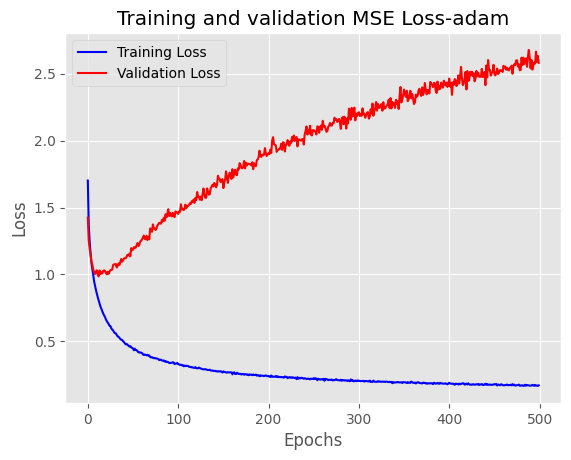

In [9]:

plt.style.use("ggplot")
plt.figure()
plt.plot(history['train loss'], 'b', label='Training Loss')
plt.plot(history['test loss'],'r', label='Validation Loss')
plt.title(f'Training and validation MSE Loss-{opt}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(f'{saving_path}/{n_layers}_MSE_{opt}_lr{lr}_cl_weight={cl_weight}_recon_weight={recon_weight}_{title}.png')
plt.show()

# 展示重构的图片

orginal result
 frog truck truck  deer   car   car  bird horse


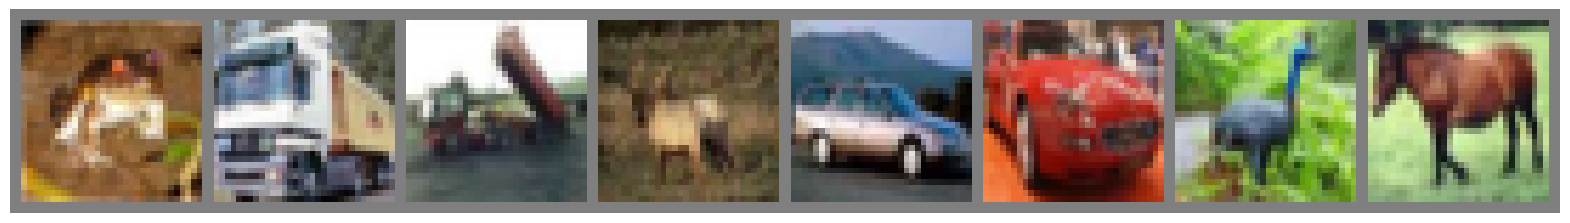

model result
 frog truck truck  deer   car   car  bird horse


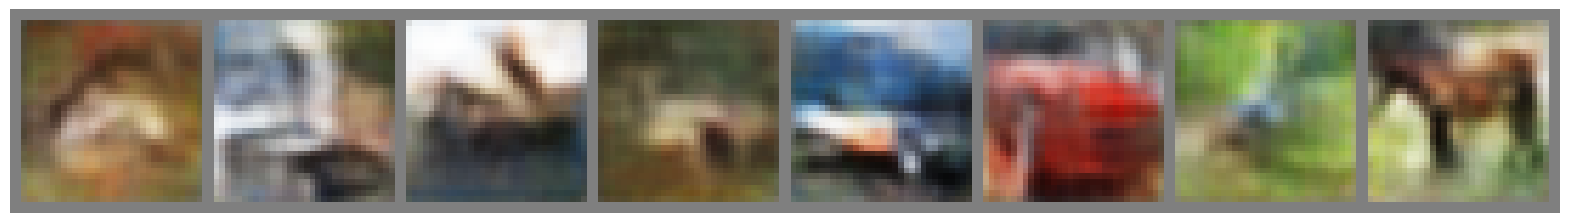

In [10]:
def torch_imshow(img):
    #img=img.permute(2,0, 1)
    img=img.transpose(0, 1)
    img=img.transpose(1, 2)
    img=img/2+0.5 #from [-1,1] to [0,1]
    plt.figure(figsize=(20,10))
    try:
        plt.imshow(img.cpu())
    except:
        plt.imshow(img.cpu().detach().numpy()) 
    plt.axis('off')
    plt.show()
# get some random training images
dataiter = iter(dataloader_train)
images, labels = dataiter.next()
# show images
print('orginal result')
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))
imshow(make_grid(images[:8]))
model.eval()
_, outputs, pre = model(images.to(device))
vectors=model.embedding(images.to(device))
outputs=outputs
_,predicted = torch.max(pre.data,1)
print('model result')
print(' '.join('%5s' % classes[predicted[j]] for j in range(8)))
torch_imshow(make_grid(outputs[:8]))

# 降维打标签

降维之前zs.shape： torch.Size([50000, 192])
降维之后zs.shape： (50000, 2)


/home/user_home/kuangjielong/.conda/envs/python3_7/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


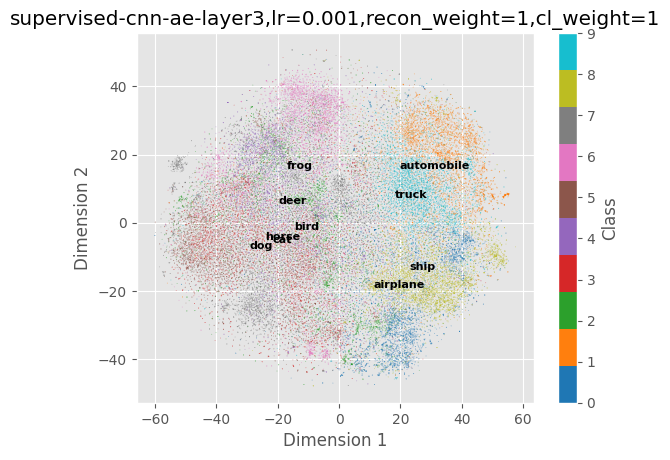

In [11]:
model.eval()
num = 0

with torch.no_grad():
    for pics, label in dataloader_train:
        pics = pics.to(device)
        z = model.embedding(pics)
        if num == 0:
            zs = z
            labels = label
            all_pics = pics
            num = 1
        else:
            zs = torch.cat((zs, z), dim = 0)
            labels = torch.cat((labels, label), dim = 0)
            all_pics = torch.cat((all_pics, pics), dim = 0)

print("降维之前zs.shape：", zs.shape)
# 可能比较耗时
from openTSNE import TSNE
zs = zs.detach().cpu()
zs = TSNE(n_jobs=4).fit(zs)  # 输出N, 2
print("降维之后zs.shape：", zs.shape)
# 绘制散点图

import torch
import numpy as np
import matplotlib.pyplot as plt

# labels = torch.load("./临时垃圾-随时可删/labels.pt")
cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

title = f"supervised-cnn-ae-layer3,lr={lr},recon_weight={recon_weight},cl_weight={cl_weight}"

# 将张量转换为 NumPy 数组
zs_np = zs
# zs_np = zs_np[:5000]
# labels = labels[:5000]

# 获取类别数量和颜色映射
color_map = plt.get_cmap("tab10")

# 绘制散点图
plt.scatter(zs_np[:, 0], zs_np[:, 1], s=0.01, c=labels, cmap=color_map)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title(title)
plt.colorbar(label="Class")

# 添加类别标签
for i in range(10):
    label = cifar10_labels[i]
    x = zs_np[labels == i, 0].mean()
    y = zs_np[labels == i, 1].mean()
    plt.text(x, y, label, fontsize=8, ha='center', va='center', weight='bold')
plt.show()

# 随机抽取一个点，看近邻

cor_origin:  [21.60782573 15.44494194]
nearest_cor:  [21.60782573 15.44494194]
nearest_cor2:  [21.54208492 15.53252809]
all_pics.shape:  torch.Size([50000, 3, 32, 32])
nearest_index： 
 [49793  4629 40157 16117 16454 47636  6546   828  5662 27917 29258 15190
 44554 34970 21212 39585]
near_imgs.shape:  torch.Size([16, 3, 32, 32])


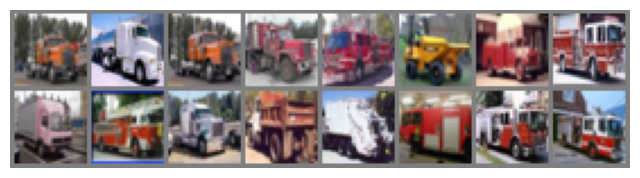

In [14]:
from scipy import spatial
import random

def torch_imshow(img):
    #img=img.permute(2,0, 1)
    img=img.transpose(0, 1)
    img=img.transpose(1, 2)
    img=img/2+0.5 #from [-1,1] to [0,1]
    plt.figure(figsize=(8,4))
    try:
        plt.imshow(img.cpu())
    except:
        plt.imshow(img.cpu().detach().numpy()) 
    plt.axis('off')
    plt.show()

# 获取所有图片

tree = spatial.KDTree(data=zs_np)
tree_data = tree.data

length = len(tree_data)
random_number = random.randint(0, length)

# 随机抽取起点下标
cor_orgin = tree_data[random_number]

nearest_distance, nearest_index = tree.query(cor_orgin, k=16)

print("cor_origin: ", cor_orgin)
print("nearest_cor: ", tree_data[nearest_index[0]])
print("nearest_cor2: ", tree_data[nearest_index[1]])

print("all_pics.shape: ", all_pics.shape)
print("nearest_index： \n", nearest_index)

for i, index in enumerate(nearest_index):
    img = all_pics[index].unsqueeze(0)
    if i == 0:
        near_imgs = img
    else: 
        near_imgs = torch.cat((near_imgs, img), dim=0)

print("near_imgs.shape: ", near_imgs.shape)
torch_imshow(make_grid(near_imgs))